# Set Up VizDoom

In [ ]:
# Change kernel to doom_venv
#!pip install vizdoom
#!pip install vizdoom[gym] dont install this, run the last gym line
#!pip install stable-baselines3[extra]
#!pip install setuptools==65.5.0 "wheel<0.40.0"
#!pip install gym==0.21.0

In [ ]:
#!cd github & git clone https://github.com/Farama-Foundation/ViZDoom

In [1]:
# Importing os for file management
import os
# Importing vizdoom for game environment
import vizdoom as vzd
# Importing random for action sampling
import random
# Importing time for sleeping
import time
# Importing numpy for operations of matrices
import numpy as np

In [2]:
# Creating the game instance
game = vzd.DoomGame()
# Loading the configuration of a scenario,
# Replace "basic.cfg" with any other scenario file
game.load_config(r"C:\Users\admin\Desktop\AI ML\Doom\ViZDoom\scenarios\basic.cfg")
#game.set_doom_scenario_path("basic.wad")
# To start the game
game.init()

In [3]:
# identity() returns an identity array 
# Set of actions that can be taken in the game env
actions = np.identity(3, dtype = np.uint8)
actions

array([[1, 0, 0],
       [0, 1, 0],
       [0, 0, 1]], dtype=uint8)

+3 actions
- Move left
- Move right
- Attack

In [4]:
# Randomly chooses the actions to carry out
# Gets replaced by PPO model
random.choice(actions)

array([0, 1, 0], dtype=uint8)

In [ ]:
# Playing 10 games
episodes = 10

# Looping through 10 episodes
for episdoe in range(episodes):
    
    # Basically restarting the game
    # If new_episode() PRODUCES AN ERROR -> RESTART THE KERNEL
    game.new_episode()
    
    # While loop runs when the game isnt finished
    while not game.is_episode_finished(): 
        # Get the game state 
        state = game.get_state()
        
        # Get the game's current image
        img = state.screen_buffer
        
        # Get the game variables - ammo for the basic config set up
        # ammo = 50
        info = state.game_variables
        
        # Executes a particular action
        # Here 4 represents the time between an action and end result
        # Skips the next 4 frames after executing an action
        # If the monster gets killed then 106 points won, else the game is over after the shot is missed
        reward = game.make_action(random.choice(actions),4)
        
        # Print reward 
        print('reward:', reward) 
        
        # Sleep timer
        time.sleep(0.02)
        
    # Getting total reward
    print('Result:', game.get_total_reward())
    time.sleep(2)

In [ ]:
# To close the game
game.close()

# Set up OpenAI Gym Environment for Reinforcement Learning

In [5]:
# Importing Env base class from OpenAI Gym
from gym import Env

# Import gym spaces 
# Discrete is a collection of actions that the agent can take, where only one can be chose at each step. There is no variability to an action in this scenario.
# Box defines a space in which the agent can act, and allows for variable forward distances in the gridworld scenario.
from gym.spaces import Discrete, Box

# Importing OpenCV for grayscaling observations to process the doom environment faster
import cv2

In [6]:
# Create Vizdoom OpenAI Gym Environment
class VizDoomGym(Env): 
    
    # Function called when env has been started
    def __init__(self, render=False):
         # Inherit from Env
        # GAME SET UP
        # The __init__() method is a special method in Python classes that are called when an object is created.
        # The super() function is often used with the __init__() method to initialize the attributes of the parent class.
        super().__init__()
        self.game = vzd.DoomGame()
        self.game.load_config(r"C:\Users\admin\Desktop\AI ML\Doom Game\ViZDoom\scenarios\basic.cfg")
        self.game.init()
        
        # Render frame logic
        # Helps in training the model faster
        if render == False: 
            # Doesnt let the window to pop up, runs in background
            self.game.set_window_visible(False)
        else:
            self.game.set_window_visible(True)
        
        # To start the game  
        self.game.init()
        
        # Define the action space and observation space
        # low, high define minimum and maximum pixels 
        self.observation_space = Box(low=0, high=255, shape=(100,160,1), dtype=np.uint8) 
        self.action_space = Discrete(3)
        
        
    # Defines how to take a step in the game env
    def step(self, action):
        # Action and rewards defined
        actions = np.identity(3)
        # 4 acts as a skip parameter
        reward = self.game.make_action(actions[action], 4) 
        
        #Explains what happens when the game starts
        if self.game.get_state(): 
            # Grabs the next frame
            state = self.game.get_state().screen_buffer
            state = self.grayscale(state)
            ammo = self.game.get_state().game_variables[0]
            info = ammo
        # Runs when the game is over
        else: 
            state = np.zeros(self.observation_space.shape)
            info = 0 
        info = {"info":info}
        done = self.game.is_episode_finished()
        
        return state, reward, done, info 
    
    # Define how to render the game or environment 
    def render(): 
        # Handled by Doom env itself
        pass
    
    
    # Runs when the game restarts
    def reset(self): 
        self.game.new_episode()
        state = self.game.get_state().screen_buffer
        return self.grayscale(state)
    
    
    # Grayscaling and resizing the frame of the game 
    # Grayscale an image is a process of converting an image from other color space like RGB to different shades of gray
    # This is done to reduce the models complexity, dimensionality reduction, allowing models to work effectively.
    def grayscale(self, observation):
        # cv2.cvtColor() converts BGR color to gray
        gray = cv2.cvtColor(np.moveaxis(observation, 0, -1), cv2.COLOR_BGR2GRAY)
        # cv2.resize() resizes the grayscale observation to (160,100)
        # cv2.INTER_CUBIC interpolation method is used to preserve the quality of the grayscale observation
        resize = cv2.resize(gray, (160,100), interpolation=cv2.INTER_CUBIC)
        # reshape() is necessary as the expected format for this process is (height,width,channel)
        state = np.reshape(resize, (100,160,1))
        return state
    
    # Function to close down the game
    def close(self): 
        self.game.close()

In [7]:
env = VizDoomGym(render=True)

In [8]:
game.close()

In [9]:
state = env.reset()

######## To check the game env
from stable_baselines3.common import env_checker
env_checker.check_env(env)

# To view the state

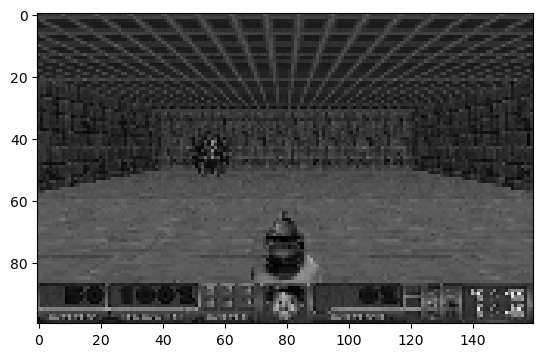

In [10]:
import matplotlib.pyplot as plt
plt.imshow(cv2.cvtColor(state, cv2.COLOR_BGR2RGB))

# Set up Callback
- Manually saves the RL model

In [11]:
from stable_baselines3.common.callbacks import BaseCallback

In [12]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [13]:
CHECKPOINT_DIR = './train/train_basic'
LOG_DIR = './logs/log_basic'

In [14]:
# check_freq set to 10000 means, the instance of the model is saved after every 10000 steps
callback = TrainAndLoggingCallback(check_freq=10000, save_path=CHECKPOINT_DIR)

# Model training

In [ ]:
from stable_baselines3 import PPO

In [ ]:
# Non rendered environment
env = VizDoomGym()

In [ ]:
# CNNPolicy is a type of neural network - check out the doc
# tensorboard_log -> logs information about the model
# verbose -> provides info while training 
# learning rate refers to how fast the model should learn
# max 300 actions per episode. 
# n_steps ???
model = PPO('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=1, learning_rate=0.0001, n_steps=512)

# low n_steps high clip_range is required

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


C:\Users\admin\anaconda3\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


In [ ]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

In [ ]:
model.learn(total_timesteps=100000, callback=callback)

Logging to ./logs/log_basic\PPO_9
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 26.6     |
|    ep_rew_mean     | -44.4    |
| time/              |          |
|    fps             | 20       |
|    iterations      | 1        |
|    time_elapsed    | 25       |
|    total_timesteps | 512      |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 30.7        |
|    ep_rew_mean          | -73         |
| time/                   |             |
|    fps                  | 18          |
|    iterations           | 2           |
|    time_elapsed         | 56          |
|    total_timesteps      | 1024        |
| train/                  |             |
|    approx_kl            | 0.014871679 |
|    clip_fraction        | 0.262       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.08       |
|    explained_variance   | 0.000139  

ViZDoomUnexpectedExitException: Controlled ViZDoom instance exited unexpectedly.

In [ ]:
model.save('sample')

In [ ]:
#ViZDoomUnexpectedExitException occurs when the application output is closed
# ep_len_mean means how many frames does the agent survive on average
# ep_rew_mean - sum of total reward
# fps - how fast the doom env is processing frames per second
# time_elapsed - actual time duration
# total_timesteps - how many time steps agent took
# approx_kl - compares the performance of previous agent and current agent. 
# If there is a spike in approx_kl -> UNSTABLE LEARNING. Ideal rate should vary but not much
# PPO clippiing is a process of handling the unstable learning bit. PPO clips the change.
# You can try increasing the clip_range and gae_lambda hyperparam if there are huge spikes in approx_kl
# check out entropy_loss
# explained_variance - how well the model is able to explain the variance in value function. Should be positive
# n_updates -> number of updates to actors, critic policy networks
# policy_gradient_loss ->how well the agent takes action to increase its advantage. Should decrease. Flucates then decrease
# value_loss ??
# if graph for approx_kl and policy_gradient_loss value is almost 0 at the end. Its an indicator that the model isnt learning well

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir logs --host localhost

Reusing TensorBoard on port 6006 (pid 22588), started 1:21:15 ago. (Use '!kill 22588' to kill it.)

# Testing

In [23]:
from stable_baselines3.common.evaluation import evaluate_policy

In [27]:
model = PPO.load(r'./train/train_basic/Basic100k')

PermissionError: [Errno 13] Permission denied: 'train\\train_basic\\Basic100k'

In [ ]:
env = VizDoomGym(render=True)

In [ ]:
# Evaluate mean reward for 10 games
mean_reward, _ = evaluate_policy(model, env, n_eval_episodes=100)

In [ ]:
mean_reward

In [ ]:
model.predict(obs)

In [ ]:
for episode in range(5): 
    obs = env.reset()
    done = False
    total_reward = 0
    while not done: 
        action, _ = model.predict(obs)
        obs, reward, done, info = env.step(action)
        # time.sleep(0.20)
        total_reward += reward
    print('Total Reward for episode {} is {}'.format(total_reward, episode))
    time.sleep(2)